In [3]:
import sys

from order_routerv2 import *  # Import module from the parent folder
import tensorflow as tf
from keras.models import load_model
from utils import*
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor
from datetime import*
import pickle as pkl

from alpaca.data.live.option import *
from alpaca.data.historical.option import *
from alpaca.data.historical import *
from alpaca.data.requests import *
from alpaca.data.timeframe import *
from alpaca.data.models import *
from alpaca.data.enums import *
from alpaca.trading.client import *
from alpaca.trading.stream import *
from alpaca.trading.requests import * 
from alpaca.trading.enums import *
from alpaca.trading.models import *


In [4]:
with open('multi_scaler3.pkl','rb') as f:
    multi_scaler=pkl.load(f)
with open('encoder.pkl','rb') as f:
    encoder=pkl.load(f)
trader=Trader(model=load_model('model3.keras'),multi_scaler=multi_scaler,encoder=encoder)


In [5]:
import pydantic

In [120]:

quote=trader.client.get_stock_latest_quote(StockLatestQuoteRequest(symbol_or_symbols='SPY'))['SPY']
chain=OptionChainRequest(underlying_symbol='SPY',feed=OptionsFeed.OPRA,strike_price_gte=quote.ask_price*0.975,strike_price_lte=quote.ask_price*1.025)
chain=trader.options_client.get_option_chain(chain)

In [127]:
symbol

'SPY250331P00522000'

In [122]:
import re

def extract_expiration_date(option_symbol):
    # Pattern captures six digits that represent the date in the option symbol
    match = re.search(r'(\d{6})[PC]\d{8}', option_symbol)
    if match:
        # Extract the date portion and format it as YYYY-MM-DD
        date_str = match.group(1)
        year = "20" + date_str[0:2]  # Assuming all dates are in the 2000s
        month = date_str[2:4]
        day = date_str[4:6]
        return date(int(year), int(month), int(day)
    else:
        return "Invalid format"
    
record=[]
for symbol,option in chain.items():
    option_type = 'Call' if 'C' in symbol else 'Put'
    strike_price = float(symbol[-8:]) / 1000  # Assuming strike price follows the last 8 digits in the symbol
    greeks=option.greeks
    implied_volatility=option.implied_volatility
    expiration_date=extract_expiration_date(symbol)
    if greeks:
        greeks=greeks.model_dump()
    else:
        greeks=dict(zip(OptionsGreeks.model_fields.keys(),[None]*7))
    
    record.append([symbol,option_type,strike_price,greeks['delta'],greeks['theta'],greeks['vega'],greeks['gamma'],greeks['rho'],implied_volatility])
chaindf=pd.DataFrame(record,columns=['symbol','type','strike','delta','theta','vega','gamma','rho','implied_volatility']).dropna().set_index(['type','strike']).sort_index()

    

In [123]:
chaindf

symbol     delta     theta      vega     gamma  \
type strike                                                               
Call 498.0   SPY240430C00498000  0.927094 -0.654997  0.036983  0.016315   
     498.0   SPY240502C00498000  0.965755 -0.156390  0.035097  0.011085   
     498.0   SPY240507C00498000  0.899869 -0.175344  0.132651  0.017445   
     498.0   SPY240508C00498000  0.895608 -0.168312  0.145027  0.017539   
     498.0   SPY240510C00498000  0.837519 -0.209804  0.217617  0.018332   
...                         ...       ...       ...       ...       ...   
Put  522.0   SPY240731P00522000 -0.534729 -0.041502  1.023238  0.010143   
     522.0   SPY241231P00522000 -0.438304 -0.021691  1.650506  0.005522   
     522.0   SPY250331P00522000 -0.407179 -0.011865  1.899250  0.005036   
     522.5   SPY240503P00522500 -0.753741 -0.614273  0.168319  0.018477   
     522.5   SPY240510P00522500 -0.778459 -0.138795  0.263231  0.020243   

                  rho  implied_volatility  
type strike                                
Call 498.0   0.012615            0.318031  
     498.0   0.039470            0.148063  
     498.0   0.097724            0.133350  
     498.0   0.109377            0.128900  
     498.0   0.124516            0.151408  
...               ...                 ...  
Put  522.0  -0.741563            0.152194  
     522.0  -1.677660            0.170459  
     522.0  -2.138944            0.157476  
     522.5  -0.043731            0.319516  
     522.5  -0.123716            0.165855  

[1098 rows x 7 columns]

(array([[<Axes: title={'center': 'delta'}>,
         <Axes: title={'center': 'theta'}>],
        [<Axes: title={'center': 'vega'}>,
         <Axes: title={'center': 'gamma'}>],
        [<Axes: title={'center': 'rho'}>,
         <Axes: title={'center': 'implied_volatility'}>]], dtype=object),
 array([[<Axes: title={'center': 'delta'}>,
         <Axes: title={'center': 'theta'}>],
        [<Axes: title={'center': 'vega'}>,
         <Axes: title={'center': 'gamma'}>],
        [<Axes: title={'center': 'rho'}>,
         <Axes: title={'center': 'implied_volatility'}>]], dtype=object))

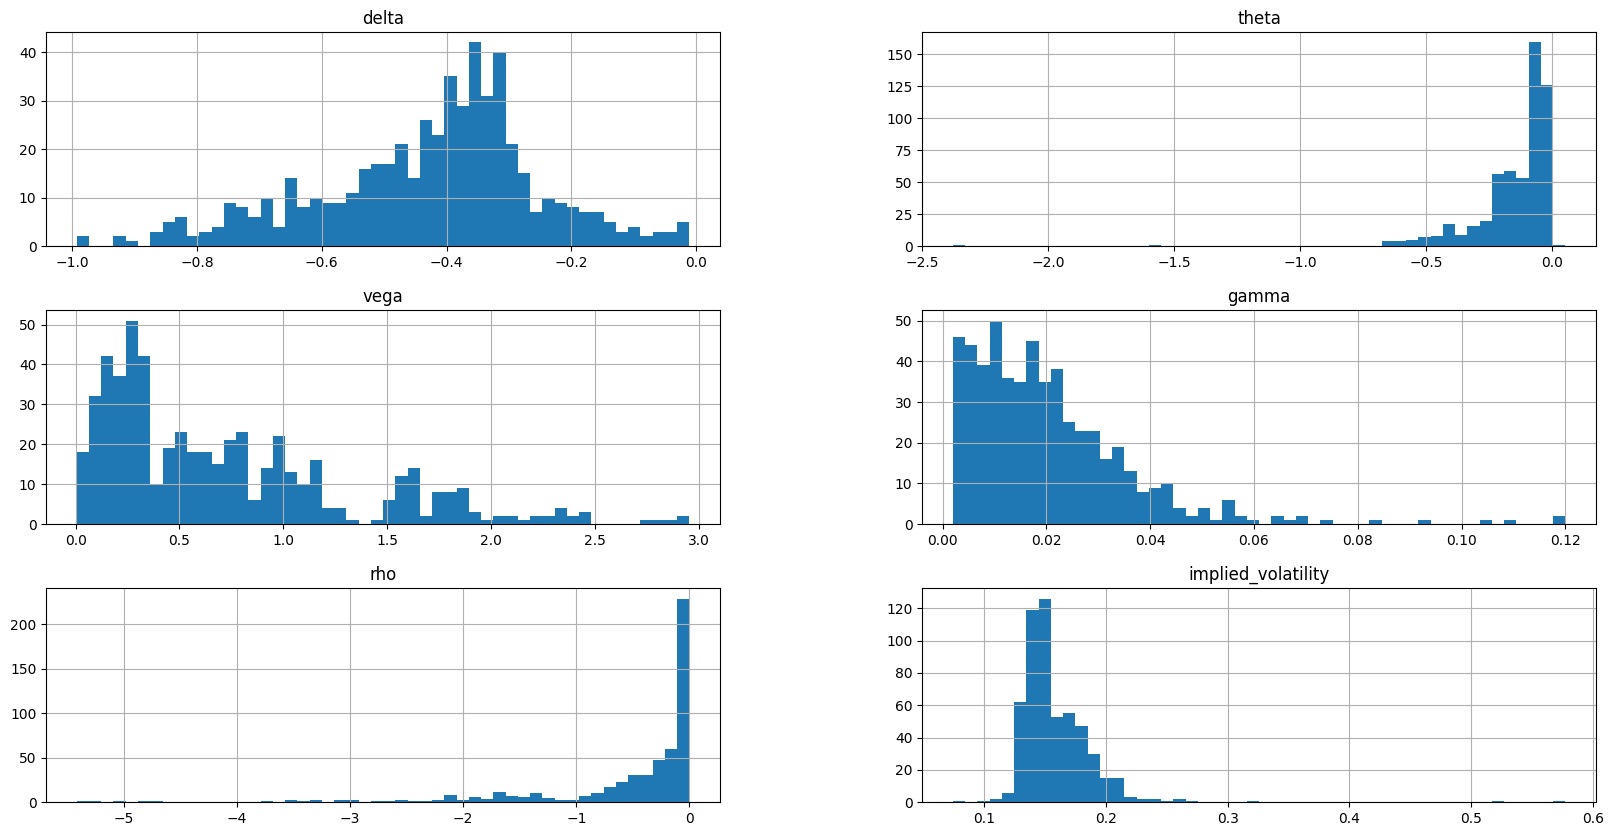

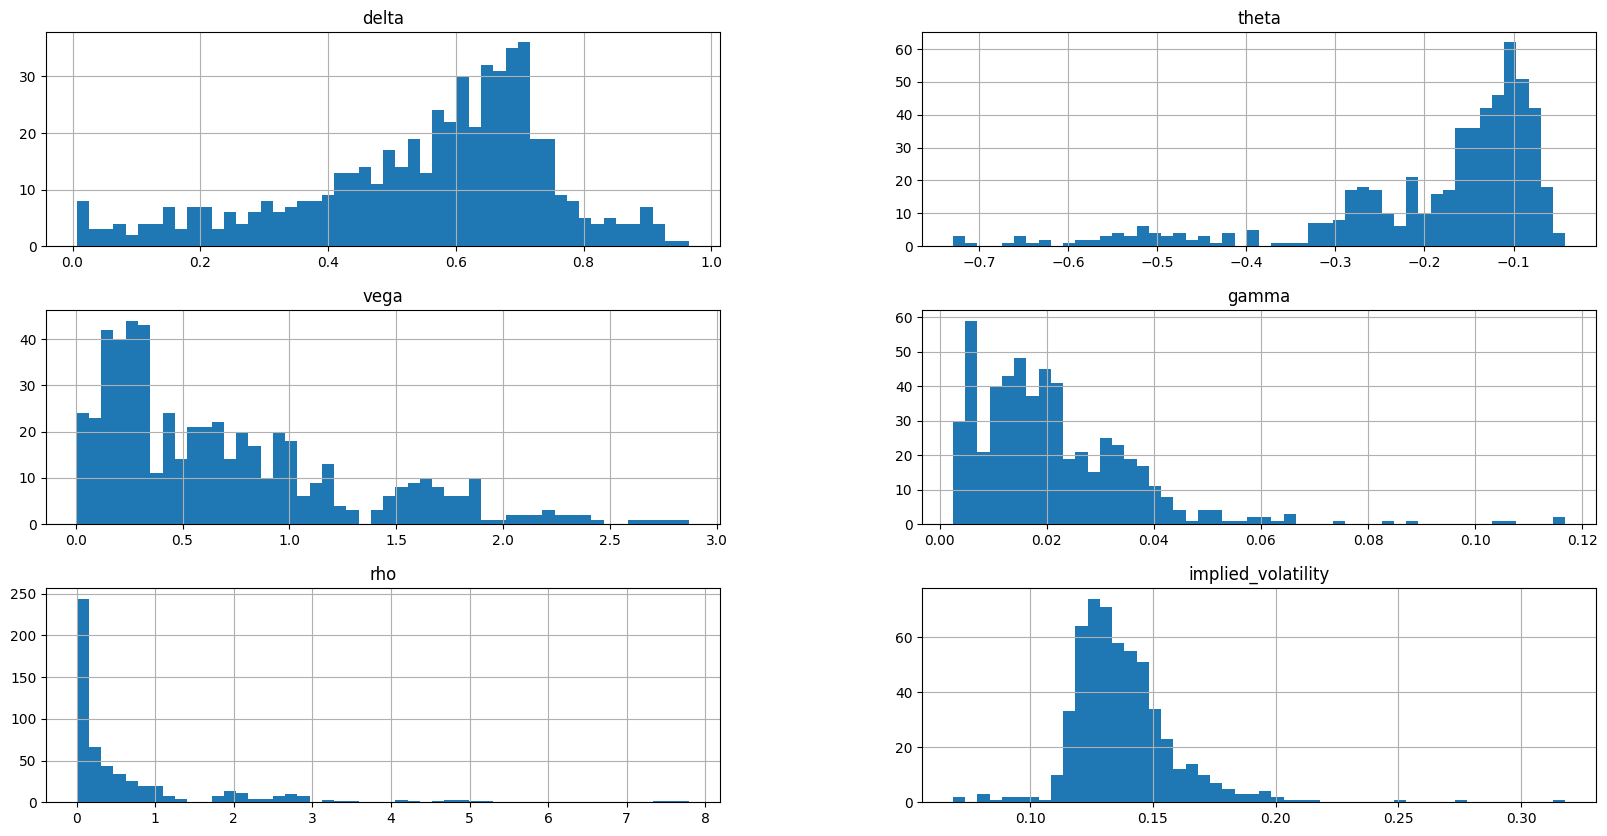

In [124]:
chaindf.loc['Put'].hist(bins=50,figsize=(20,10)),chaindf.loc['Call'].hist(bins=50,figsize=(20,10))

In [66]:
import QuantLib as ql
maturity_date = ql.Date(15, 1, 2016)
spot_price = 127.62
strike_price = 130
volatility = 0.20 # the historical vols or implied vols
dividend_rate =  0.0163
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(1)

calculation_date = ql.Date(8, 5, 2015)
ql.Settings.instance().evaluationDate = calculation_date
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date

am_exercise = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)
steps = 200
binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
american_option.setPricingEngine(binomial_engine)

print (american_option.NPV())


6.84210328728556
